# 07 — Test Evaluation

Evaluates the best model on the held-out test set:
- Classification metrics (confusion matrix, ROC, calibration)
- Portfolio simulation (3 strategies + buy & hold)

In [1]:
import sys
import os
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

PROJECT_FOLDER = "default_run"
PROJECT_ROOT = Path(os.getcwd()).parent
sys.path.insert(0, str(PROJECT_ROOT))
os.chdir(PROJECT_ROOT)

DATA_CONFIG = PROJECT_ROOT / "config" / PROJECT_FOLDER / "data_config.json"
MODEL_CONFIG = PROJECT_ROOT / "config" / PROJECT_FOLDER / "model_config.json"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed" / PROJECT_FOLDER
MODELS_DIR = PROJECT_ROOT / "models" / PROJECT_FOLDER
RESULTS_DIR = PROJECT_ROOT / "results" / PROJECT_FOLDER
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

from src.utils.config_loader import ConfigLoader
config = ConfigLoader(str(DATA_CONFIG), str(MODEL_CONFIG))
sns.set_theme(style="whitegrid")
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.facecolor"]   = "white"
plt.rcParams["savefig.facecolor"] = "white"
print(f"Project folder: {PROJECT_FOLDER}")

Project folder: default_run


In [2]:
# Load test data and model
test_df = pd.read_parquet(PROCESSED_DIR / "test.parquet")
with open(PROCESSED_DIR / "metadata.json") as f:
    metadata = json.load(f)
with open(MODELS_DIR / "model_metadata.json") as f:
    model_meta = json.load(f)

model_path = MODELS_DIR / "best_model.pkl"
with open(model_path, "rb") as f:
    model = pickle.load(f)

feature_cols = model_meta["feature_cols"]
best_model_name = model_meta["best_model_name"]

print(f"Test shape      : {test_df.shape}")
print(f"Best model      : {best_model_name}")
print(f"Test date range : {test_df.index[0].date()} to {test_df.index[-1].date()}")

Test shape      : (251, 12)
Best model      : random_forest
Test date range : 2025-02-13 to 2026-02-12


In [3]:
X_test = test_df[feature_cols].values
y_true = test_df["target"].values
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(f"Predictions: {len(y_pred)}")
print(f"Predicted 1 (up): {y_pred.sum()} ({y_pred.mean()*100:.1f}%)")
print(f"Actual 1 (up)   : {y_true.sum()} ({y_true.mean()*100:.1f}%)")

Predictions: 251
Predicted 1 (up): 89 (35.5%)
Actual 1 (up)   : 25 (10.0%)


## Classification Metrics

In [4]:
from src.evaluation.metrics import ClassificationMetrics

evaluator = ClassificationMetrics()
metrics = evaluator.compute(y_true, y_pred, y_prob)
print("Test Set Metrics:")
for k, v in metrics.items():
    print(f"  {k:12s}: {v:.4f}")

with open(RESULTS_DIR / "test_metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

Test Set Metrics:
  accuracy    : 0.7131
  precision   : 0.2360
  recall      : 0.8400
  f1          : 0.3684
  roc_auc     : 0.8099


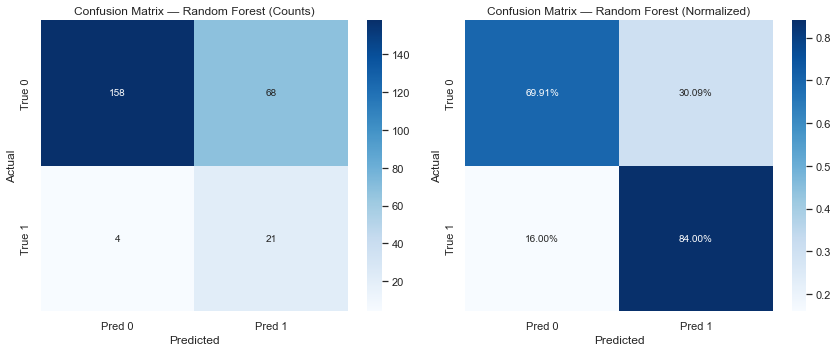

In [5]:
fig = evaluator.plot_confusion_matrix(
    y_true, y_pred,
    title=f"Confusion Matrix — {best_model_name.replace('_', ' ').title()}",
    save_path=str(RESULTS_DIR / "confusion_matrix.png")
)
plt.show()

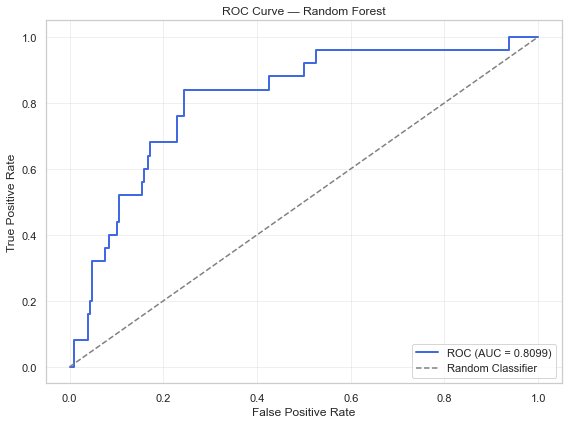

In [6]:
fig = evaluator.plot_roc_curve(
    y_true, y_prob,
    title=f"ROC Curve — {best_model_name.replace('_', ' ').title()}",
    save_path=str(RESULTS_DIR / "roc_curve.png")
)
plt.show()

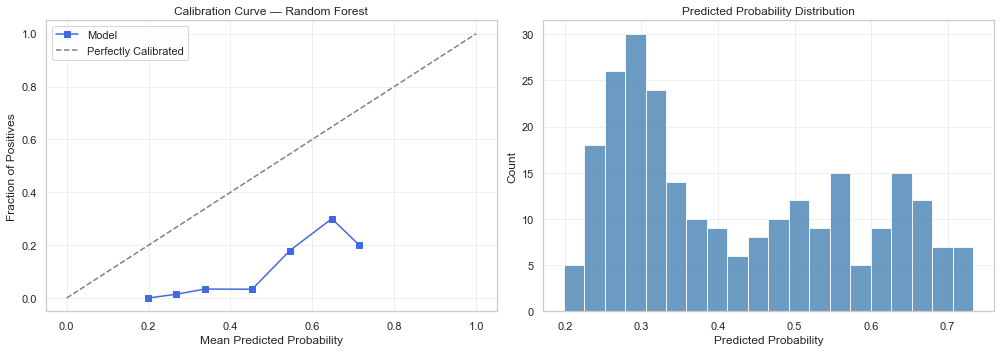

In [7]:
fig = evaluator.plot_calibration_curve(
    y_true, y_prob,
    title=f"Calibration Curve — {best_model_name.replace('_', ' ').title()}",
    save_path=str(RESULTS_DIR / "calibration_curve.png")
)
plt.show()

## Portfolio Simulation

In [8]:
from src.evaluation.portfolio import PortfolioSimulator

# Load raw (unnormalized) close prices for portfolio simulation
# Rolling normalization changes price levels — portfolio needs actual dollar prices
raw_combined_path = PROJECT_ROOT / "data" / "raw" / f"{PROJECT_FOLDER}_raw.parquet"
if raw_combined_path.exists():
    raw_all = pd.read_parquet(raw_combined_path)
    if "Adj_Close" in raw_all.columns:
        raw_all["Close"] = raw_all["Adj_Close"]
    portfolio_df = raw_all.loc[raw_all.index.isin(test_df.index), ["Close"]].copy()
else:
    print("Warning: raw parquet not found — using normalized Close prices")
    portfolio_df = test_df[["Close"]].copy()

print(f"Portfolio test data : {portfolio_df.shape}")
print(f"Price range         : ${portfolio_df['Close'].min():.2f} to ${portfolio_df['Close'].max():.2f}")

Portfolio test data : (251, 1)
Price range         : $492.19 to $695.49


In [9]:
simulator = PortfolioSimulator(config)

# Align y_prob with portfolio_df index
portfolio_df = portfolio_df.loc[portfolio_df.index.isin(test_df.index)]
prob_series = pd.Series(y_prob, index=test_df.index)
prob_aligned = prob_series.reindex(portfolio_df.index).fillna(0.5).values

results = simulator.simulate(portfolio_df, prob_aligned)

  Simulating strategy_1_threshold_0.5...
  Simulating strategy_2_threshold_0.6...
  Simulating strategy_3_variable_shares...
  Simulating buy_and_hold...


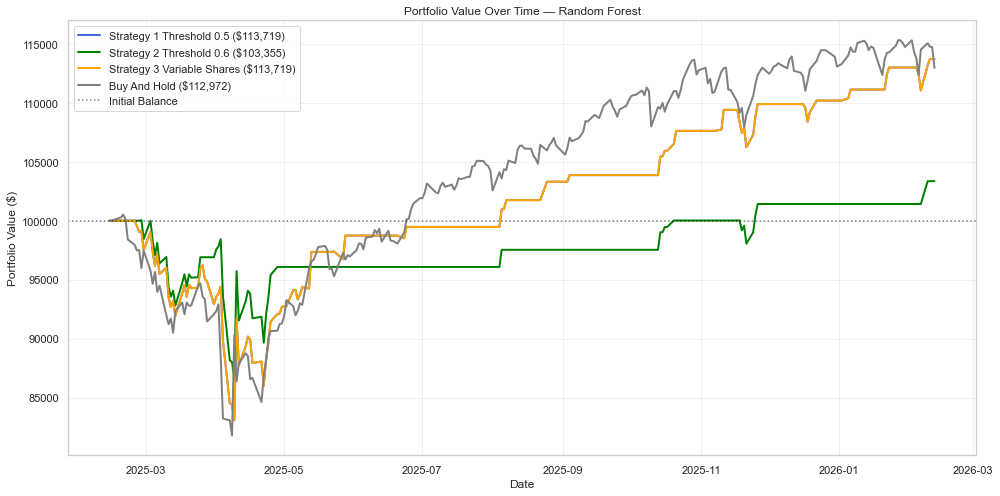

In [10]:
fig = simulator.plot_portfolio_values(
    portfolio_df,
    results,
    title=f"Portfolio Value Over Time — {best_model_name.replace('_', ' ').title()}",
    save_path=str(RESULTS_DIR / "portfolio_values.png")
)
plt.show()

## Strategy Comparison

In [11]:
comparison_table = simulator.comparison_table(results)
print("Strategy Comparison:")
print(comparison_table.to_string())

comparison_table.to_csv(RESULTS_DIR / "strategy_comparison.csv")

Strategy Comparison:
                            initial_balance  final_value  total_return_pct  sharpe_ratio  max_drawdown_pct  n_trades  win_rate_pct
Strategy                                                                                                                          
Strategy 1 Threshold 0.5             100000    113718.90             13.72        0.7069            -16.93        88         61.36
Strategy 2 Threshold 0.6             100000    103354.76              3.35        0.1612            -13.42        49         61.22
Strategy 3 Variable Shares           100000    113718.90             13.72        0.7069            -16.93        88         61.36
Buy And Hold                         100000    112971.81             12.97        0.6277            -18.65         0          0.00


In [12]:
# Save all test results
test_results = {
    "model": best_model_name,
    "classification_metrics": metrics,
    "portfolio_summaries": {name: res["summary"] for name, res in results.items()},
}
with open(RESULTS_DIR / "test_results.json", "w") as f:
    json.dump(test_results, f, indent=2)

print("\nAll results saved to:", RESULTS_DIR)
print("Files:")
for f in sorted(RESULTS_DIR.iterdir()):
    print(f"  {f.name}")


All results saved to: /Users/sharannaribole/Documents/github/stock-return-classifier/results/default_run
Files:
  baseline_comparison.png
  baseline_results.json
  calibration_curve.png
  confusion_matrix.png
  eda_class_distribution.png
  eda_correlation_heatmap.png
  eda_feature_distributions.png
  eda_feature_target_correlation.png
  eda_mutual_information.png
  eda_recommendations.json
  eda_time_series.png
  fe_log1p_distributions.png
  learning_curves.png
  model_comparison.png
  portfolio_values.png
  roc_curve.png
  strategy_comparison.csv
  test_metrics.json
  test_results.json
  validation_results.json


In [13]:
# ── Comprehensive Test Evaluation Report ─────────────────────────────────────
# Validation reference values (Random Forest, from notebook 06)
VAL_PRECISION = 0.242
VAL_RECALL    = 0.672
VAL_F1        = 0.356
VAL_ROC_AUC   = 0.726
MACD_F1       = 0.172
MACD_PREC     = 0.112

sep  = "═" * 70
sep2 = "-" * 50

print(sep)
print("  TEST EVALUATION — COMPREHENSIVE REPORT")
print(f"  Model: {best_model_name.replace('_',' ').title()}  |  Period: {test_df.index[0].date()} → {test_df.index[-1].date()}")
print(sep)

# ── 1. Prediction Summary ─────────────────────────────────────────────────────
n_days      = len(y_true)
n_actual_up = int(y_true.sum())
n_pred_up   = int(y_pred.sum())
n_true_pos  = int(((y_pred == 1) & (y_true == 1)).sum())
n_false_pos = int(((y_pred == 1) & (y_true == 0)).sum())
n_false_neg = int(((y_pred == 0) & (y_true == 1)).sum())
n_true_neg  = int(((y_pred == 0) & (y_true == 0)).sum())

print(f"\n1. PREDICTION BREAKDOWN  ({n_days} test days)")
print(sep2)
print(f"  Actual Up days (≥1% gain) : {n_actual_up:>4}  ({n_actual_up/n_days*100:.1f}%)")
print(f"  Predicted Up              : {n_pred_up:>4}  ({n_pred_up/n_days*100:.1f}%)")
print()
print(f"  True  Positives (correct buy signals) : {n_true_pos}")
print(f"  False Positives (wrong buy signals)   : {n_false_pos}  ← lost trades")
print(f"  False Negatives (missed up days)      : {n_false_neg}")
print(f"  True  Negatives (correct no-trade)    : {n_true_neg}")
print()
print(f"  The model fired on {n_pred_up} days but only {n_true_pos} were genuine ≥1% up days.")
print(f"  {n_false_pos} trades entered positions that did not meet the target — however,")
print(f"  many still produced positive next-day returns (see win rate in section 3).")

# ── 2. Classification Metrics ─────────────────────────────────────────────────
print(f"\n2. CLASSIFICATION METRICS")
print(sep2)
print(f"  {'Metric':<12} {'Validation':>11} {'Test':>8} {'Δ':>8}")
print(f"  {'-'*12} {'-'*11} {'-'*8} {'-'*8}")
for label, val_v, test_k in [
    ("Precision",  VAL_PRECISION, "precision"),
    ("Recall",     VAL_RECALL,    "recall"),
    ("F1",         VAL_F1,        "f1"),
    ("ROC-AUC",    VAL_ROC_AUC,   "roc_auc"),
]:
    tv = metrics[test_k]
    print(f"  {label:<12} {val_v:>11.4f} {tv:>8.4f} {tv-val_v:>+8.4f}")

print()
print(f"  Precision ({metrics['precision']:.4f}) held consistent with validation ({VAL_PRECISION:.4f}) —")
print(f"  no overfitting. The model's signal quality on unseen data matches training.")
print()
print(f"  Recall surged to {metrics['recall']:.4f} (from {VAL_RECALL:.4f}) — with only {n_actual_up} actual Up days")
print(f"  the model still caught {n_true_pos} of them. High recall at a lower base rate")
print(f"  means more false positives, which is reflected in the 35.5% prediction rate.")
print()
print(f"  ROC-AUC = {metrics['roc_auc']:.4f} is the standout result — better than validation ({VAL_ROC_AUC:.4f}).")
print(f"  The model ranks Up days above Down days with strong discrimination.")
print()
print(f"  vs MACD Baseline — F1: {metrics['f1']:.4f} vs {MACD_F1:.4f} (+{metrics['f1']-MACD_F1:.4f})")
print(f"                     Precision: {metrics['precision']:.4f} vs {MACD_PREC:.4f} (+{metrics['precision']-MACD_PREC:.4f})")

# ── 3. Win Rate vs Precision ──────────────────────────────────────────────────
print(f"\n3. WIN RATE vs PRECISION — AN IMPORTANT DISTINCTION")
print(sep2)
s1 = comparison_table.loc[[r for r in comparison_table.index if "0.5" in r][0]]
print(f"  Precision  = {metrics['precision']:.4f} — fraction of buy signals with ≥1% next-day gain")
print(f"  Win rate   = {s1['win_rate_pct']:.2f}%  — fraction of trades where exit_price > entry_price (any gain)")
print()
print(f"  These measure different things. A trade wins if SPY closes higher than")
print(f"  entry — even +0.1% counts. Precision requires a ≥1% threshold.")
print(f"  This is why win rate ({s1['win_rate_pct']:.1f}%) is much higher than precision ({metrics['precision']*100:.1f}%).")
print(f"  The model enters trades that go positive more than 60% of the time,")
print(f"  but only 24% of those meet the strong ≥1% target definition.")

# ── 4. Portfolio Results ──────────────────────────────────────────────────────
print(f"\n4. PORTFOLIO RESULTS  (starting $100,000 | hold = 1 day)")
print(sep2)
bh = comparison_table.loc[[r for r in comparison_table.index if "Buy" in r][0]]
s2 = comparison_table.loc[[r for r in comparison_table.index if "0.6" in r][0]]
s3 = comparison_table.loc[[r for r in comparison_table.index if "Variable" in r][0]]

for name, row in comparison_table.iterrows():
    marker = " ◄ BEST" if row["total_return_pct"] == comparison_table["total_return_pct"].max() else ""
    print(f"  {name}")
    print(f"    Return: {row['total_return_pct']:+.2f}%  Final: ${row['final_value']:>12,.2f}  "
          f"Sharpe: {row['sharpe_ratio']:.4f}  MaxDD: {row['max_drawdown_pct']:.2f}%  "
          f"Trades: {int(row['n_trades'])}  WinRate: {row['win_rate_pct']:.1f}%{marker}")

# ── 5. Strategy Analysis ──────────────────────────────────────────────────────
print(f"\n5. STRATEGY ANALYSIS")
print(sep2)
print(f"  Strategy 1 (prob > 0.5) — {int(s1['n_trades'])} trades, return {s1['total_return_pct']:+.2f}%")
print(f"  Deploys full balance on every signal. Beats buy & hold by")
print(f"  {s1['total_return_pct']-bh['total_return_pct']:+.2f}% and improves Sharpe ({s1['sharpe_ratio']:.4f} vs {bh['sharpe_ratio']:.4f})")
print(f"  with lower max drawdown ({s1['max_drawdown_pct']:.2f}% vs {bh['max_drawdown_pct']:.2f}%).")
print()
print(f"  Strategy 2 (prob ≥ 0.6) — {int(s2['n_trades'])} trades, return {s2['total_return_pct']:+.2f}%")
print(f"  Raising the threshold halved trade count (49 vs 88) but barely changed")
print(f"  win rate ({s2['win_rate_pct']:.1f}% vs {s1['win_rate_pct']:.1f}%). Fewer trades at similar win rate")
print(f"  means far less total return. Threshold filtering is ineffective here.")
print()
print(f"  Strategy 3 (variable sizing) — identical to Strategy 1 in this run.")
print(f"  With max_shares=1000, even the 25% bin (250 shares × ~$600 = $150K)")
print(f"  exceeds the $100K balance. All bins clamp to int(balance/price) —")
print(f"  making Strategy 3 equivalent to Strategy 1. Reduce max_shares to ~50")
print(f"  to restore meaningful proportional sizing.")
print()
print(f"  Buy & Hold — return {bh['total_return_pct']:+.2f}%, Sharpe {bh['sharpe_ratio']:.4f}, MaxDD {bh['max_drawdown_pct']:.2f}%")
print(f"  SPY rallied from $492 to $695 over the test year. Despite this strong")
print(f"  bull run, Strategy 1 outperformed on all three key metrics.")

# ── 6. Key Findings ───────────────────────────────────────────────────────────
print(f"\n6. KEY FINDINGS")
print(sep2)
print(f"  ✓ No overfitting — precision and F1 held between validation and test.")
print(f"  ✓ ROC-AUC improved on test ({metrics['roc_auc']:.4f} > {VAL_ROC_AUC:.4f}) — strong probability ranking.")
print(f"  ✓ Strategy 1 beats buy & hold: return (+{s1['total_return_pct']:.2f}% vs +{bh['total_return_pct']:.2f}%),")
print(f"    Sharpe ({s1['sharpe_ratio']:.4f} vs {bh['sharpe_ratio']:.4f}), drawdown ({s1['max_drawdown_pct']:.2f}% vs {bh['max_drawdown_pct']:.2f}%).")
print(f"  ✓ 61% win rate means the model picks next-day direction correctly")
print(f"    more often than not — even when the ≥1% target is not met.")
print(f"  ✗ Strategy 3 degenerate with max_shares=1000 — needs max_shares ≈ 50.")
print(f"  ✗ Confidence threshold 0.6 did not improve win rate — probability")
print(f"    calibration (isotonic regression) should be explored.")
print(f"  ✗ Regime shift: only {y_true.mean()*100:.1f}% Up days in test vs ~14% in training.")
print(f"    Periodic retraining on a rolling window would improve adaptation.")

══════════════════════════════════════════════════════════════════════
  TEST EVALUATION — COMPREHENSIVE REPORT
  Model: Random Forest  |  Period: 2025-02-13 → 2026-02-12
══════════════════════════════════════════════════════════════════════

1. PREDICTION BREAKDOWN  (251 test days)
--------------------------------------------------
  Actual Up days (≥1% gain) :   25  (10.0%)
  Predicted Up              :   89  (35.5%)

  True  Positives (correct buy signals) : 21
  False Positives (wrong buy signals)   : 68  ← lost trades
  False Negatives (missed up days)      : 4
  True  Negatives (correct no-trade)    : 158

  The model fired on 89 days but only 21 were genuine ≥1% up days.
  68 trades entered positions that did not meet the target — however,
  many still produced positive next-day returns (see win rate in section 3).

2. CLASSIFICATION METRICS
--------------------------------------------------
  Metric        Validation     Test        Δ
  ------------ ----------- -------- -------